<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 36px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  LAB-02: LÀM VIỆC VÀ TRỰC QUAN HÓA DỮ LIỆU CHUỖI THỜI GIAN<Title>
</div>

<h2>Nhóm 23</h2>
<h3>Thông tin nhóm:</h3>


<center>

| HỌ TÊN                | MSSV      |
|:------------------    |:--------: |
| Lê Công Đắt     | 20120454  |
| Lê Trần Minh Khuê     | 21120279  |
| Hoàng Trung Nam       | 21120290  |
| Lê Trần Như Ngọc       | 21120296  |
| Lê Thị Minh Phương | 21120533  |

</center>


<h2>Giảng viên hướng dẫn:</h2>

### **Thầy Lê Nhựt Nam**

<h2>Chủ đề:</h2>

## ***Phân tích và trực quan giá cổ phiếu của top 6 ngân hàng có trị thương hiệu tốt nhất Việt Nam***

---


# **Phần C: Khám phá mối quan hệ trong dữ liệu.**
## **C04. Kiểm tra tính dừng của của các time series về giá cổ phiếu và xây dựng các mô hình dự đoán giá cổ phiếu**

#### ***Sơ lược nội dung:***
1. Kiểm tra tính dừng của các time series về giá cổ phiếu.
2. Xây dựng mô hình SARIMA và mô hình LSTM để dự đoán giá cổ phiếu.


## **I. Chuẩn bị** 

### 1. Nhập các thư viện

In [22]:
# Nhập các thư viện cần dùng
import numpy as np
import pandas as pd

# Các thư viện để vẽ hình
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Các thư viện stats
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings("ignore")


### 2. Nhập dữ liệu

In [5]:
# Nhập data đã xử lý từ pha B 
full_df = pd.read_csv("./Data/full_data_processed.csv ")
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Xem dữ liệu
full_df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,Stock symbol,Bank
0,2018-06-04,10633.7,10028.5,10633.7,10028.5,18000000.0,6.96,VPB,VPBank
1,2018-06-04,44960.0,42837.0,45187.0,42458.0,4900000.0,4.04,VCB,Vietcombank
2,2018-06-04,23343.0,22195.0,23419.5,21735.7,6140000.0,2.69,BID,BIDV
3,2018-06-04,3425.1,3307.0,3425.1,3218.4,112900.0,6.75,AGR,Agribank
4,2018-06-04,20839.3,20429.2,20951.1,20168.3,7570000.0,1.82,CTG,VietinBank


## **II. Phân tích và trực quan hoá.** <a id=”ii-phân-tích-và-trực-quan-hoá″></a>

### **1. Kiểm tra tính dừng của các time series về giá cổ phiếu.**

#### **Thông tin đang quan tâm:**
- Các time series về giá cổ phiếu của từng ngân hàng có thỏa mãn tính dừng hay không?

#### **Hướng tiếp cận:**
- Lấy các time series của thuộc tính `Price` của từng ngân hàng theo thời gian.
- Đánh giá tính dừng bằng cách quan sát biểu đồ biểu diễn giá trị của time series theo thời gian.
- Đánh giá tính dừng sử dụng thống kê mô tả trên từng đoạn của time series (chunking).
- Đánh giá tính dừng sử dụng biểu đồ histogram và normal test để kiểm tra xấp xỉ phân phối chuẩn.
- Đánh giá tính dừng sử dụng ADF test.


In [6]:
# Tạo dictionary chứa các dataframe ứng với từng ngân hàng
grouped_df = full_df.groupby('Bank')
dataframes = {name: group for name, group in grouped_df}

In [9]:
# Định nghĩa hàm lấy dataframe theo tên ngân hàng
# Sort lại theo Date và cho phép tùy chọn kiểu index
def get_bank_df(bankname, date_index=True):
    df = dataframes[bankname]
    df = df.sort_values(by='Date')
    if (date_index==False):
        df.reset_index(drop=True, inplace=True)
    else:
        df.set_index('Date', inplace=True)
    return df

#### **1.1. Khảo sát chi tiết tính dừng của time series về giá cổ phiếu với ngân hàng Agribank.**

**Tính dừng (stationarity):**

*Tính dừng là một điều kiện quan trọng đối với dữ liệu time series. Nhiều mô hình dự đoán time series yêu cầu dữ liệu đảm bảo tính dừng.*

- **Tính dừng ngặt** (strict stationarity): Một time series thỏa mãn tính dừng ngặt nếu bất kỳ các time series con bất kỳ của nó có cùng phân phối (không phụ thuộc vào thời gian).
> Trên thực tế, tính dừng ngặt thường khó thỏa mãn. Do đó ta định nghĩa một tiêu chuẩn lỏng lẻo hơn, sao cho đủ hữu dụng và thỏa mãn được, đó là tính dừng yếu.

- **Tính dừng yếu** (weak stationarity): Một time series thỏa mãn tính dừng yếu nếu: (1) Giá trị trung bình của các time series con không đổi theo thời gian, (2) phương sai của các time series con không đổi theo thời gian và (3) hiệp phương sai giữa hai time series con chỉ phụ thuộc vào khoảng cách thời gian giữa chúng.
> Điều kiện (3) nghĩa là hiệp phương sai giữa $X(t)$ và $X(t+h)$ chỉ phụ thuộc vào $h$.

Dưới đây, chúng ta khảo sát tính dừng yếu của các time series về giá cổ phiếu cho từng ngân hàng. Để ngắn gọn, từ đây, chúng ta sẽ gọi **tính dừng** để chỉ **tính dừng yếu**. Khi đó, ta khảo sát xem time series có thỏa mãn các điều kiện sau đây:
- Giá trị trung bình không đổi theo thời gian (đồng nghĩa với việc không có *xu hướng*). #1
- Phương sai không đổi theo thời gian (hiện tượng phương sai thay đổi được gọi là *heteroskedasticity*). #2
- Cấu trúc hiệp phương sai không đổi theo thời gian (chỉ phụ thuộc vào khoảng cách thời gian - `lag` giữa các time series con). #3

Có nhiều phương pháp để kiểm tra tính dừng của một time series, mỗi phương pháp có một ưu nhược điểm riêng và có những trường hợp áp dụng khác nhau. Để kết quả đánh giá đáng tin cậy, ta cần kết hợp nhiều cách khác nhau. Dưới đây, chúng ta sẽ khảo sát tính dừng của time series với 4 kỹ thuật bao gồm:
- **Run-sequence plots**: Trực quan time series cùng rolling mean, rolling variance và đánh giá xem sự thay đổi của chúng theo thời gian.
- **Summary statistics**: Chia time series thành các phần nhỏ bằng nhau (chunking) để kiểm tra sự thay đổi giá trị trung bình và phương sai.
- **Histogram plots**: Vẽ biểu đồ histogram của time series để đánh giá sự xấp xỉ của time series về phân phối chuẩn.
- **Normal test**: Sử dụng kiểm định thống kê để kiểm tra time series có tuân theo phân phối chuẩn hay không.
- **Augmented Dickey-Fuller test**: Sử dụng kiểm định ADF test để kiểm tra tính dừng của time series.

In [10]:
AGR_df = get_bank_df(bankname='Agribank', date_index=True)
AGR_df.head(2)

,Price,Open,High,Low,Vol.,Change %,Stock symbol,Bank
Date,,,,,,,,
2018-06-04,3425.1,3307.0,3425.1,3218.4,112900.0,6.75,AGR,Agribank
2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR,Agribank


##### **1.1.1. Run-sequence plot**
Trực quan time series cùng rolling mean, rolling variance và đánh giá xem sự thay đổi của chúng theo thời gian. Ở đây, ta chọn `window`=30, nghĩa là quan sát liên tục các time series con dài 30 ngày để tính rolling mean và rolling std. Đối với phương pháp này, ta đánh giá tính dừng một cách thủ công.

In [13]:
# Định nghĩa hàm Run-sequence plot 
def plot(series, series_name):
    # Tính rolling mean và rolling std
    rolmean = series.rolling(window=30).mean()
    rolstd = series.rolling(window=30).std()

    # Trực quan time series, rolling mean và rolling std
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='tab:blue',label='Series')
    plt.plot(rolmean, color='tab:red', label='Rolling Mean')
    plt.plot(rolstd, color='darkorange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{series_name} Over Time with Rolling Mean and Standard Deviation')
    plt.grid(); 

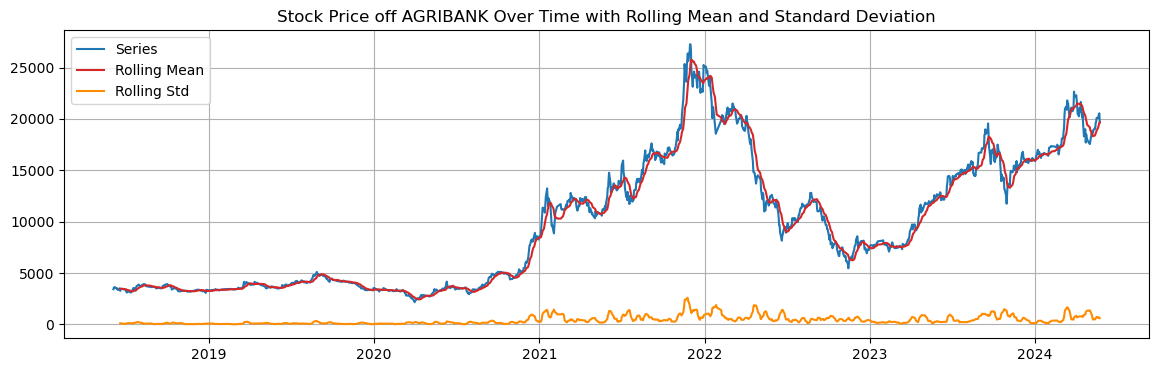

In [12]:
plot(series=AGR_df['Price'], series_name='Stock Price off AGRIBANK')

**Nhận xét:**
- Từ đường màu xanh biểu diễn time series, ta thấy giá trị của time series thay đổi theo thời gian và có mức độ thay đổi khác nhau nhiều trong từng giai đoạn. 
- Đồng thời (cụ thể hơn), đường màu đỏ biểu diễn rolling mean thay đổi nhiều cho thấy giá trị trung bình của các time series con thay đổi theo thời gian; đường màu cam biểu diễn rolling std thì thay đổi không nhiều (nếu xét trên cùng khoảng giá trị), tuy nhiên vẫn có thay đổi - trước năm 2021 độ lệch chuẩn không đổi nhưng sau năm 2021 thì có thay đổi.
- Ta có thể đánh giá cảm tính rằng giá trị trung bình có thay đổi theo thời gian (vi phạm điều kiện #1), phương sai có thay đổi, nhưng ta không biết sự thay đổi này có ý nghĩa hay không (có thể vi phạm điều kiện #2 hoặc không). Với đánh giá này, time series trên ***không thỏa mãn tính dừng***.
- Trong đánh giá này, có những điều kiện ta chưa thể khẳng định chắc chắn là có bị vi phạm hay không. Do đó cần kết hợp thêm những phương pháp khác. Tuy nhiên, như đã đề cập, các phương pháp dù là tự động hay thủ công đều có ưu nhược điểm riêng, và việc đánh giá thủ công trong phương pháp này vẫn là một điều cần thiết.

##### **1.1.2. Summary Statistics**
Chia time series thành các phần nhỏ bằng nhau (chunking) để kiểm tra sự thay đổi giá trị trung bình và phương sai. Phương pháp này đòi hỏi sự đánh giá thủ công.

In [15]:
def summary_statistics(series, series_name):
    print(f'Statistical Chunking Summary of {series_name}')
    if len(series) >= 10:
        # Chia time series thành 10 chunk
        chunks = np.array_split(series, 10)
        
        # Tính giá trị trung bình và phương sai trên từng chunk
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [17]:
summary_statistics(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK')

Statistical Chunking Summary of Stock Price of AGRIBANK
Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3475.8	 | 4.8106e+04
 2	 | 3735.4	 | 8.0827e+04
 3	 | 3835.9	 | 3.3749e+05
 4	 | 3591.1	 | 5.8736e+05
 5	 | 9568.3	 | 7.3838e+06
 6	 | 1.7217e+04	 | 1.7529e+07
 7	 | 1.5749e+04	 | 2.4969e+07
 8	 | 8435.8	 | 3.1573e+06
 9	 | 1.3484e+04	 | 8.4388e+06
10	 | 1.7431e+04	 | 5.9252e+06


In [19]:
# Giá trị trung bình của chunk 7 / Giá trị trung bình của chunk 1
1.7431e+04/3475.8

5.014960584613614

In [18]:
# Phương sai của chunk 7 / Phương sai của chunk 1
2.4969e+07/4.8106e+04

519.0412838315386

**Nhận xét:**
- Giá trị trung bình thay đổi nhiều (ví dụ giá trị trung bình của chunk 10 lớn gấp 5 lần giá trị trung bình của chunk 1). Giá trị hiệp phương sai cũng thay đổi nhiều (ví dụ hiệp phương sai của chunk 7 lớn gấp 500 lần hiệp phương sai của chunk 1).
- Ta có thể đánh giá một cách cảm tính rằng time series trên ***không thỏa mãn tính dừng***.

##### **1.1.3. Histogram plot**
Vẽ biểu đồ histogram của time series để đánh giá sự xấp xỉ của time series về phân phối chuẩn. Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán rằng giá trị trung bình và phương sai của các time series con là không đổi theo thời gian. 

Phương pháp này yêu cầu sự đánh giá thủ công.

In [20]:
def histogram_plot(series, series_name):
    plt.figure(figsize=(10, 6))
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(f'Histogram of {series_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

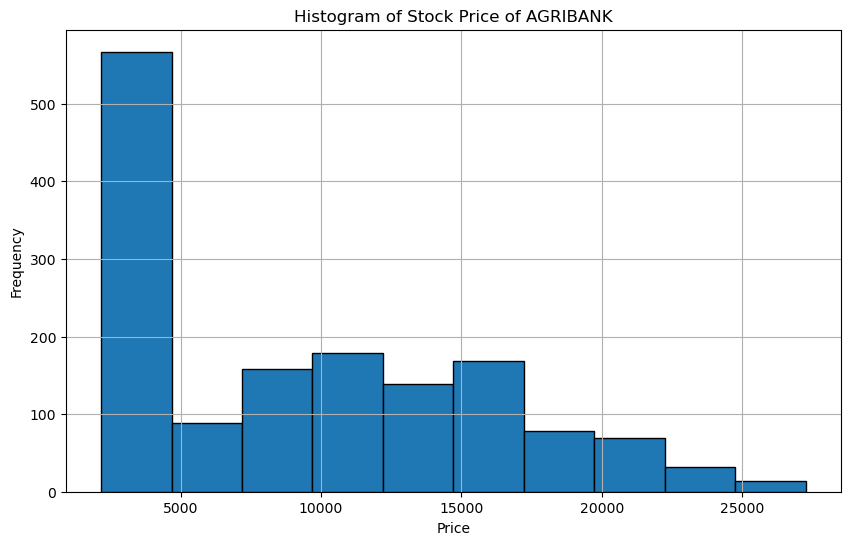

In [21]:
histogram_plot(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK')

**Nhận xét:**
- Dựa vào biểu đồ histogram, ta thấy time series khác xa so với phân phối chuẩn (đặc biệt là ở bin đầu tiên). 
- Từ quan sát này, ta có thể kết luận rằng time series trên ***không thỏa mãn tính dừng***.
- Ở phương pháp này, sự đánh giá tính dừng có phần dễ dàng hơn thông qua điều kiện suy diễn là xấp xỉ phân phối chuẩn. Ta có sử dụng kiểm định **normal test** để đánh giá sự khác biệt giữa phân phối của time series so với phân phối chuẩn.

##### **1.1.4. Normal test**
Sử dụng kiểm định thống kê để kiểm tra time series có xấp xỉ phân phối chuẩn hay không. Ở đây, ta sử dụng hàm kiểm định `normaltest` của thư viện `scipy.stats`. Hàm `normaltest` cho phép kiểm tra một mẫu có khác biệt so với phân phối chuẩn hay không. Hàm dựa trên kiểm định của D'Agostino and Pearson's kết hợp độ lệch (skew) và độ nhọn (kurtosis).

Giả thuyết $H_0$: Dữ liệu tuân theo phân phối chuẩn.

In [23]:
def normal_test(series, series_name, significance_level=0, prints=True):
    k2, pvalue = normaltest(series)

    # In chi tiết kết quả kiểm định nếu được yêu cầu
    if (prints == True):
        print(f"Normality Test Result for {series_name}:")
        print(f"Statistic: {k2:.4f}")
        print(f"P-value: {pvalue:.4f}")

        # In kết luận nếu mức ý nghĩa thống kê được cung cấp
        if significance_level > 0:
            if (pvalue < significance_level):
                print(f"The null hypothesis of normality is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of normality CANNOT BE REJECTED (significant level {significance_level}).")
    
    # Trả về kết quả 
    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [24]:
_ = normal_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

Normality Test Result for Stock Price of AGRIBANK:
Statistic: 180.1440
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).


**Nhận xét:**
- Giá trị `p-value` rất thấp xấp xỉ 0, do đó ta dễ dàng bác bỏ giả thuyết $H_0$. Ta kết luận rằng time series không xấp xỉ phân phối chuẩn, do đó ***không thỏa mãn tính dừng***.

##### **1.1.5. Augmented Dickey-Fuller (ADF) Test**
Kiểm định ADF kiểm tra sự có mặt của **unit root** trong một chuỗi thời gian. Unit root là một thuật ngữ mô tả một điều kiện cụ thể trong biểu diễn tự hồi quy (autoregressive) của một chuỗi thời gian, chỉ ra rằng chuỗi này không thỏa mãn dừng.

Một time series có unit root thì nó không thỏa mãn tính dừng. Ở đây, ta sử dụng hàm `adfuller` của thư viện [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) với phương pháp xác định độ trễ tự động là `AIC`. Ý tưởng cơ bản của kiểm định ADF là đánh giá xem các giá trị trong quá khứ của một time series có giúp dự đoán giá trị hiện tại hay không (tự hồi quy).

Giả thuyết $H_0$: Time series có chứa unit root, do đó không thỏa mãn tính dừng.

**Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.**

In [28]:
def adf_test(series, series_name, significance_level=0, prints=True):
    adf, pvalue, _, _, _, _ = adfuller(series, autolag='AIC')
    
    if (prints == True):
        print(f"ADF Test Result for {series_name}:")
        print("ADF Statistic:", adf)
        print("p-value:", pvalue)

        if (significance_level > 0):
            if pvalue < significance_level:
                print(f"The null hypothesis of non-stationarity is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level {significance_level}).")

    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [29]:
_ = adf_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

ADF Test Result for Stock Price of AGRIBANK:
ADF Statistic: -1.2487299252705506
p-value: 0.652290190381921
The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level 0.05).


**Nhận xét:**
- Kết quả kiểm định cho thấy `p-value` khá cao, do đó ta khó bác bỏ giả thuyết $H_0$. Với mức ý nghĩa 0.05 ta không thể bác bỏ giả thuyết $H_0$, do đó ta kết luận rằng time series ***không thỏa mãn tính dừng***. 

##### **Nhận xét chung:**
- Kết quả của cả 5 phương pháp trên đều đưa đến kết luận rằng ***time series về giá cổ phiếu của ngân hàng Agribank không thỏa mãn tính dừng***. 
- Đối với time series này, ta dễ dàng đánh giá tính dừng bởi vì nó vi phạm những điều kiện dễ phát hiện như giá trị trung bình thay đổi. Do đó ta có thể chọn lựa một trong các phương pháp để đánh giá. Tuy nhiên, cần phải khẳng định lại, để có thể đánh giá được chính xác tính dừng (đặc biệt là trong các trường hợp khó hơn với những điều kiện bị vi phạm khó phát hiện hơn) ta cần kết hợp các phương pháp để có thể đưa ra đánh giá chính xác và toàn diện. 

#### **1.2. Đánh giá nhanh về tính dừng của các time series giá cổ phiếu của tất cả các ngân hàng.**

Ta đã đánh giá và nhận xét chi tiết về tính dừng của time series về giá cổ phiếu của ngân hàng Agribank trong phần trên (1.1). Ở phần này, ta chỉ đánh giá nhanh và đưa ra kết luận vì nhận xét khá tương tự như đối với phần 1.1.

**Sub-sequence plots**

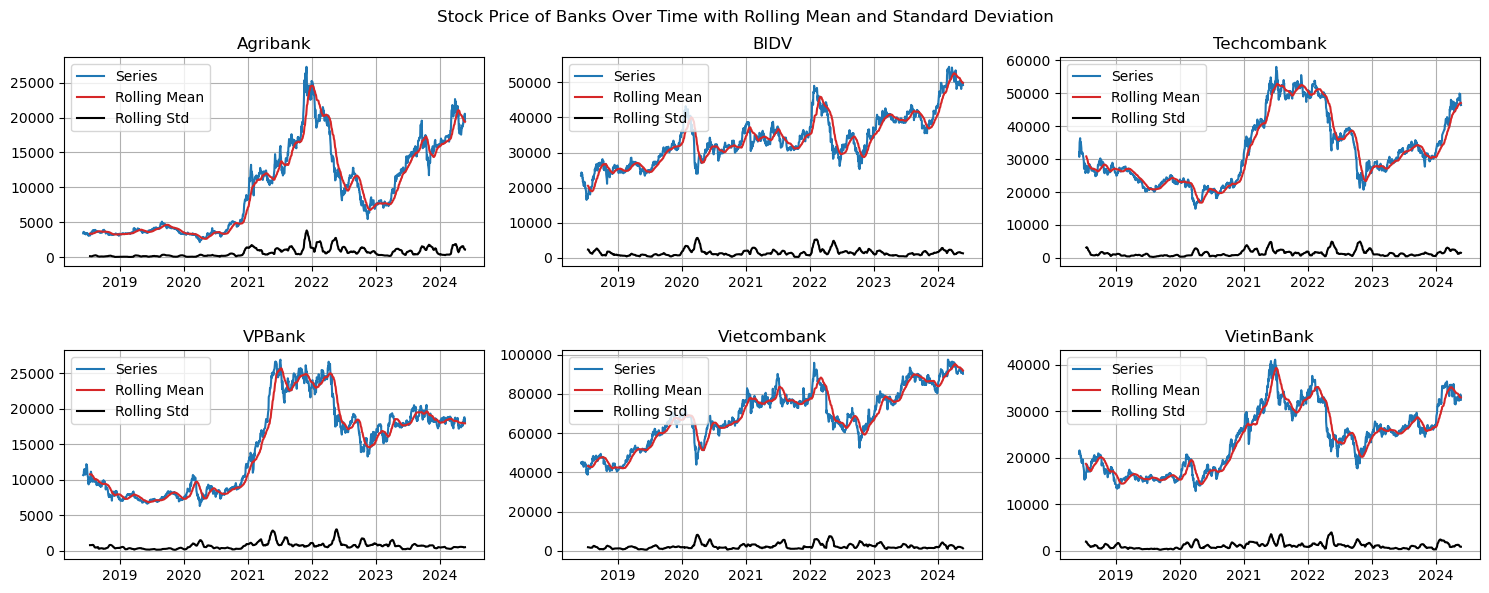

In [30]:
num_plots = len(dataframes)
cols = 3
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, series_name in enumerate(dataframes.keys(), 1):
    series = get_bank_df(series_name)['Price']

    plt.subplot(rows, cols, i)
    # Compute rolling statistics
    rolmean = series.rolling(window=30).mean()
    rolstd = series.rolling(window=30).std()

    # Plot rolling statistics:
    plt.plot(series, color='tab:blue',label='Series')
    plt.plot(rolmean, color='tab:red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(series_name)
    plt.grid(); 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Stock Price of Banks Over Time with Rolling Mean and Standard Deviation')
plt.show()

Từ các sub-sequence plot, ta thấy tất cả các time series đều có giá trị trung bình và phương sai thay đổi. 

**Histogram plots**

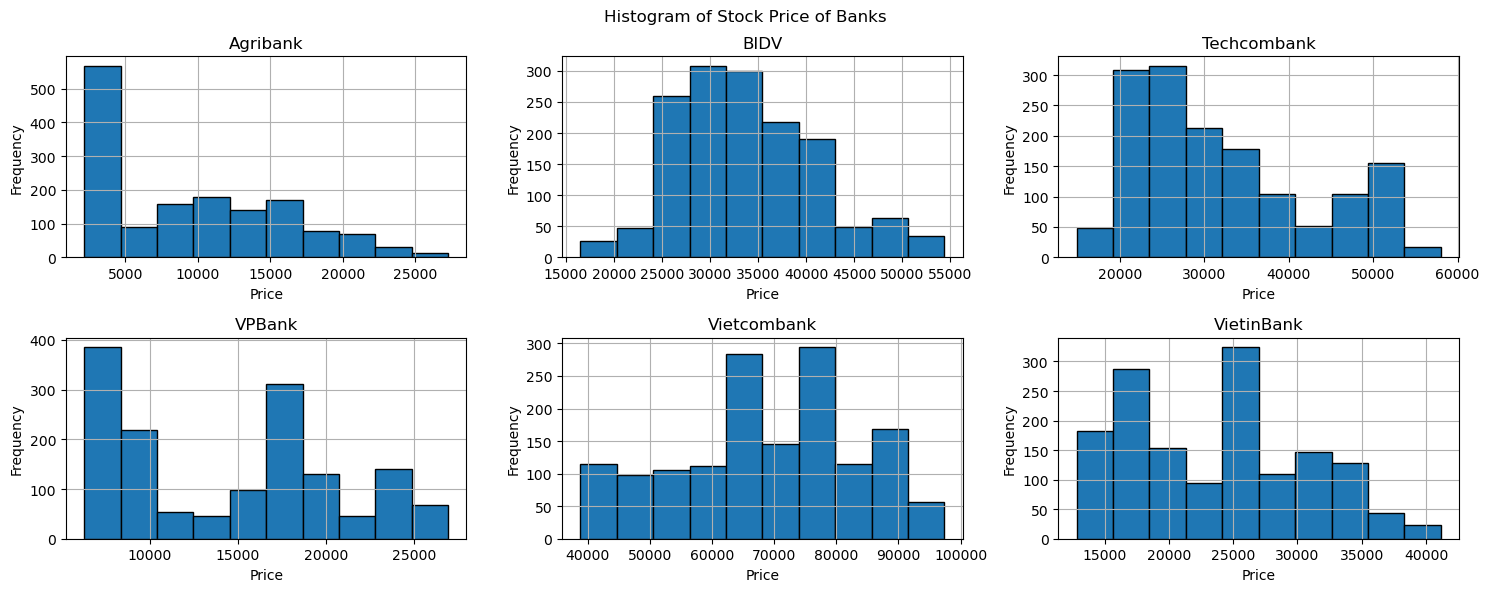

In [31]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, series_name in enumerate(dataframes.keys(), 1):
    series = get_bank_df(series_name)['Price']

    plt.subplot(rows, cols, i)
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(series_name)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Histogram of Stock Price of Banks')
plt.show()

Từ các biểu đồ histogram, ta thấy phân phối của time series ứng với giá cổ phiếu của ngân hàng BIDV gần với phân phối chuẩn hơn cả (nhưng có vẻ vẫn không đủ xấp xỉ), phân phối của các time series còn lại có sự khác biệt nhiều so với phân phối chuẩn. Tính dừng của time series ứng với ngân hàng BIDV chưa kết luận ngay được, nhưng với các ngân hàng còn lại ta có thể nhận xét rằng chúng không thỏa mãn tính dừng.

**Normal test và ADF test**

In [34]:
sig_level = 0.01
results = []

for series_name in dataframes.keys():
    series = get_bank_df(series_name)['Price']
    normal_result = normal_test(series, series_name, significance_level=sig_level, prints=False)
    adf_result = adf_test(series, series_name, significance_level=sig_level, prints=False)
    results.append([series_name, normal_result, adf_result])

print(f"Normal Test and ADF Test Results for Stock Price (significant level {sig_level}):")
pd.DataFrame(results, columns=['Price Series', 'Normal', 'Non-stationary'])

Normal Test and ADF Test Results for Stock Price (significant level 0.01):


,Price Series,Normal,Non-stationary
0,Agribank,Rejected,Cannot be rejected
1,BIDV,Rejected,Cannot be rejected
2,Techcombank,Rejected,Cannot be rejected
3,VPBank,Rejected,Cannot be rejected
4,Vietcombank,Rejected,Cannot be rejected
5,VietinBank,Rejected,Cannot be rejected


Từ bảng kết quả trên, ta thấy với mức ý nghĩa 0.01 thì:
- Đối với normal test, giả thuyết $H_0$ bị bác bỏ đối với tất cả các time series, tức là bác bỏ giả thuyết rằng các time series tuân theo phân phối chuẩn. Do đó, các time series không thỏa mãn tính dừng.
- Đối với adf test, giả thuyết $H_0$ không thể bị bác bỏ đối với tất cả các time series, tức là không thể bác bỏ giả thuyết rằng các time series không thỏa mãn tính dừng. Do đó, các time series không thỏa mãn tính dừng.

#### **Nhận xét:**
- Với kết quả từ các phương pháp trên, ta kết luận rằng ***tất cả các time series ứng với giá cổ phiếu của tất cả 6 ngân hàng đều không thỏa mãn tính dừng***. 
- Việc đánh giá tính dừng của các time series này khá đơn giản vì giá cổ phiếu biến động nhiều theo thời gian, do đó các điều kiện dễ phát hiện như giá trị trung bình và phương sai thay đổi.
- Tuy nhiên, có thể nhận xét rằng pattern của các time series này không rõ ràng (nguyên nhân là bởi vì giá cổ phiếu bị tác động bởi rất nhiều yếu tố khác nhau như kết quả kinh doanh của công ty, nền kinh tế, quy luật cung cầu và các thông tin liên quan...). **Xu hướng** của các time series thay đổi nhiều lần với các mức độ khác nhau trong từng giai đoạn. **Tính chu kỳ** của time series không rõ ràng (đối với các ngân hàng BIDV và Vietcombank thì có phần ít biến động hơn). Do đó, ở câu hỏi tiếp theo, ta sẽ thử xây dựng một số mô hình để dự đoán các time series này.    

### **2. Xây dựng mô hình SARIMA và mô hình LSTM để dự đoán giá cổ phiếu.**


##### **Thông tin đang quan tâm:**
- Xây dựng các mô hình dự đoán giá cổ phiếu của ngân hàng.
- Đánh giá độ chính xác của các mô hình đã xây dựng.

##### **Hướng tiếp cận:**
- Lấy ra time series về giá cổ phiếu của ngân hàng BIDV.
- Chia time series thành 2 phần: phần `train_set` (90%) để xây dựng mô hình, phần `test_set` (10%) để dự đoán và đánh giá độ chính xác của mô hình.
- Các mô hình dự đoán sẽ xây dựng: SARIMA, LSTM.


#### **2.1. Mô hình SARIMA**

Để hiểu được mô hình SARIMA, chúng ta cần đi qua các các mô hình đơn giản hơn. Ở đây chúng ta sẽ điểm qua các mô hình AR, MA, ARMA, từ đó hiểu về SARIMA. 
**Mô hình Autoregressive (AR):** Mô hình AR là một mô hình time series trong đó sử dụng các giá trị trong quá khứ để xây dựng một phương trình hồi quy có thể dự đoán giá trị trong tương lai. 
$$
X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + ... + \phi_p X(t-p) + \epsilon_t
$$ 
với
- $X(t)$: Giá trị của time series tại thời điểm $t$.
- $c$: Hằng số.
- $\phi_1, \phi_2,..., \phi_p$: Các hệ số của mô hình.
- $p$: Order của mô hình AR (số giá trị trong quá khứ để dựa đoán giá trị tiếp theo).
- $\epsilon_t$: White noise tại thời điểm $t$.

In [38]:
BID_df = get_bank_df(bankname='BIDV', date_index=False)

In [70]:
from math import floor,ceil
from pmdarima.arima import auto_arima

def auto_arima_prediction(df, train_ratio=0.75):
    # Determine the size of the dataset
    shape = df.shape[0]
    df_new = df.copy()
    data = df_new.sort_index(ascending=True, axis=0)
    
    # Split the data into training and validation sets
    train_set = data[:ceil(shape * train_ratio)]
    valid_set = data[ceil(shape * train_ratio):]
    
    print('----------------------------------------------------------')
    print('-----------STOCK Close PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    
    # Extract the training data
    training = train_set['Price']
    
    # Fit the auto ARIMA model
    model = auto_arima(
        training, 
        start_p=1, start_q=1, 
        max_p=3, max_q=3, 
        m=12, start_P=0, 
        seasonal=True, 
        d=1, D=1, 
        trace=True, 
        error_action='ignore', 
        suppress_warnings=True
    )
    model.fit(training)
    
    # Forecast the values for the validation set
    forecast = model.predict(n_periods=ceil(shape * (1 - train_ratio)))
    forecast = pd.DataFrame(forecast, index=valid_set.index, columns=['Prediction'])
    
    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power((np.array(valid_set['Price']) - np.array(forecast['Prediction'])), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_set['Price'], label='Model Training Data')
    plt.plot(valid_set['Price'], label='Actual Data')
    plt.plot(forecast['Prediction'], label='Predicted Data')
    plt.xlabel('Date', size=10)
    plt.ylabel('Price', size=10)
    plt.title('Stock Price Prediction by Auto ARIMA', size=20)
    plt.legend()
    plt.show()

    return rms

----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1121, 9)
Shape of Validation Set: (373, 9)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18587.419, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18266.985, Time=1.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18588.460, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18148.088, Time=2.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18146.382, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=18265.037, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.41

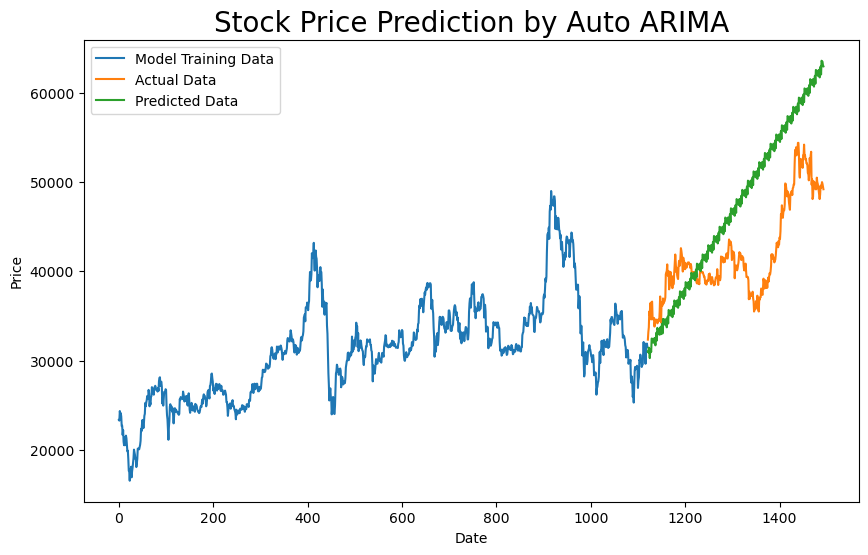

In [71]:
loss_sarima = auto_arima_prediction(BID_df)

----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1345, 9)
Shape of Validation Set: (149, 9)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=22302.964, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21935.507, Time=1.70 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=22303.236, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=21785.241, Time=3.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=21783.327, Time=0.74 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=21934.202, Time=0.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.55

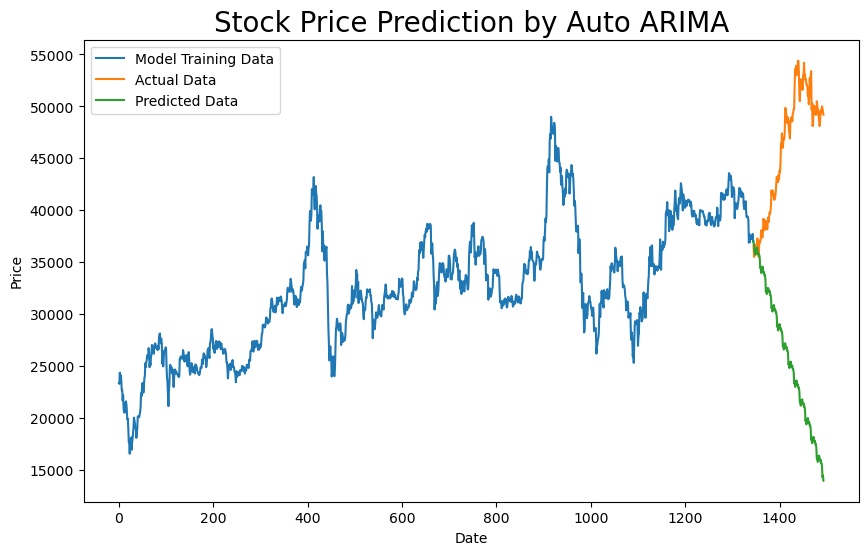

In [61]:
_ = auto_arima_prediction(BID_df, train_ratio=0.9)

**Nhận xét:**
- Từ biểu đồ trực quan, ta có thể đánh giá rằng kết quả dự đoán của mô hình có sự khác biệt lớn so với giá trị thực tế, không khớp với sự biến động xu hướng trong time series. 
- Kết quả dự đoán của mô hình SARIMA khá đơn giản với chu kỳ và xu hướng **tĩnh** (ví dụ như trong hình thứ nhất thì xu hướng chung là tăng và chu kỳ là 12 như đã chỉ định). 
- Trong mô hình thứ nhất, vì cuối `train_set` xu hướng đang tăng nên kết quả dự đoán cũng có xu hướng tăng; trong mô hình thứ hai, vì cuối `train_set` xu hướng giảm nên kết quả dự đoán có xu hướng giảm (**xu hướng cố định trong toàn bộ khoảng thời gian cần dự đoán**). Cách dự đoán này của mô hình SARIMA hoàn toàn không phù hợp đối với những time series có xu hướng biến động như giá cổ phiếu.

#### **2.1. Mô hình LSTM**

**Long Short Term Memory (LSTM):** LSTM là một loại kiến trúc Recurrent Neural Network (RNN) nhằm giải quyết vấn đề vanishing gradient của mô hình RNN truyền thống khi giải quyết các bài toán dạng chuỗi có gap length lớn (hay nói cách khác là có long-term dependencies). 

Một trong những ứng dụng phổ biến của LSTM đó là dự đoán time series. Ở đây, chúng ta không đi chi tiết vào LSTM vì nó đòi hỏi trình bày nhiều kiến thức về học sâu - nằm ngoài nội dung của môn học và mục tiêu của đồ án. Vì vậy, ta tập trung vào việc sử dụng kiến trúc LSTM được xây dựng sẵn bởi một high-level framework là `Keras` để có thể thực hiện dự đoán.

In [ ]:
! pip install TensorFlow

In [ ]:
! pip install tf_keras

In [72]:
from sklearn.preprocessing import MinMaxScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM
from math import ceil, sqrt

def lstm_prediction(df, train_ratio=0.75, epochs=1):
    window_size = 40
    # Ensure there are enough data points
    if df.shape[0] < window_size:
        print("Not enough data to train the model. Need at least window_size data points.")
        return

    # Prepare data
    df_new = df[['Price']]
    dataset = df_new.values
    train_size = ceil(df.shape[0] * 0.75)
    
    train = df_new[:train_size]
    valid = df_new[train_size:]
    
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set:', train.shape)
    print('Shape of Validation Set:', valid.shape)
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Create training data
    x_train, y_train = [], []
    for i in range(window_size, len(train)):
        x_train.append(scaled_data[i-window_size:i, 0])
        y_train.append(scaled_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Build and train the LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(units=50),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2)
    
    # Prepare test data
    inputs = df_new[len(df_new) - len(valid) - window_size:].values
    inputs = scaler.transform(inputs.reshape(-1, 1))
    
    x_test = []
    for i in range(window_size, inputs.shape[0]):
        x_test.append(inputs[i-window_size:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Make predictions
    closing_price = model.predict(x_test)
    closing_price = scaler.inverse_transform(closing_price)
    
    # Calculate RMSE
    rms = sqrt(np.mean(np.power((valid.values - closing_price), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Plot results
    valid['Predictions'] = closing_price
    plt.figure(figsize=(16, 8))
    plt.plot(train['Price'], label='Train')
    plt.plot(valid['Price'], label='Valid')
    plt.plot(valid['Predictions'], label='Prediction')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
    plt.legend()
    plt.show()

    return rms

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1121, 1)
Shape of Validation Set: (373, 1)
Epoch 1/10
1081/1081 - 13s - loss: 0.0026 - 13s/epoch - 12ms/step
Epoch 2/10
1081/1081 - 8s - loss: 0.0012 - 8s/epoch - 7ms/step
Epoch 3/10
1081/1081 - 8s - loss: 8.0066e-04 - 8s/epoch - 7ms/step
Epoch 4/10
1081/1081 - 8s - loss: 7.5162e-04 - 8s/epoch - 7ms/step
Epoch 5/10
1081/1081 - 8s - loss: 6.6822e-04 - 8s/epoch - 7ms/step
Epoch 6/10
1081/1081 - 8s - loss: 6.3243e-04 - 8s/epoch - 7ms/step
Epoch 7/10
1081/1081 - 8s - loss: 6.3894e-04 - 8s/epoch - 7ms/step
Epoch 8/10
1081/1081 - 8s - loss: 5.6930e-04 - 8s/epoch - 7ms/step
Epoch 9/10
1081/1081 - 9s - loss: 6.1022e-04 - 9s/epoch - 8ms/step
Epoch 10/10
1081/1081 - 10s - loss: 5.5302e-04 - 10s/epoch - 9ms/step
12/12 [========================

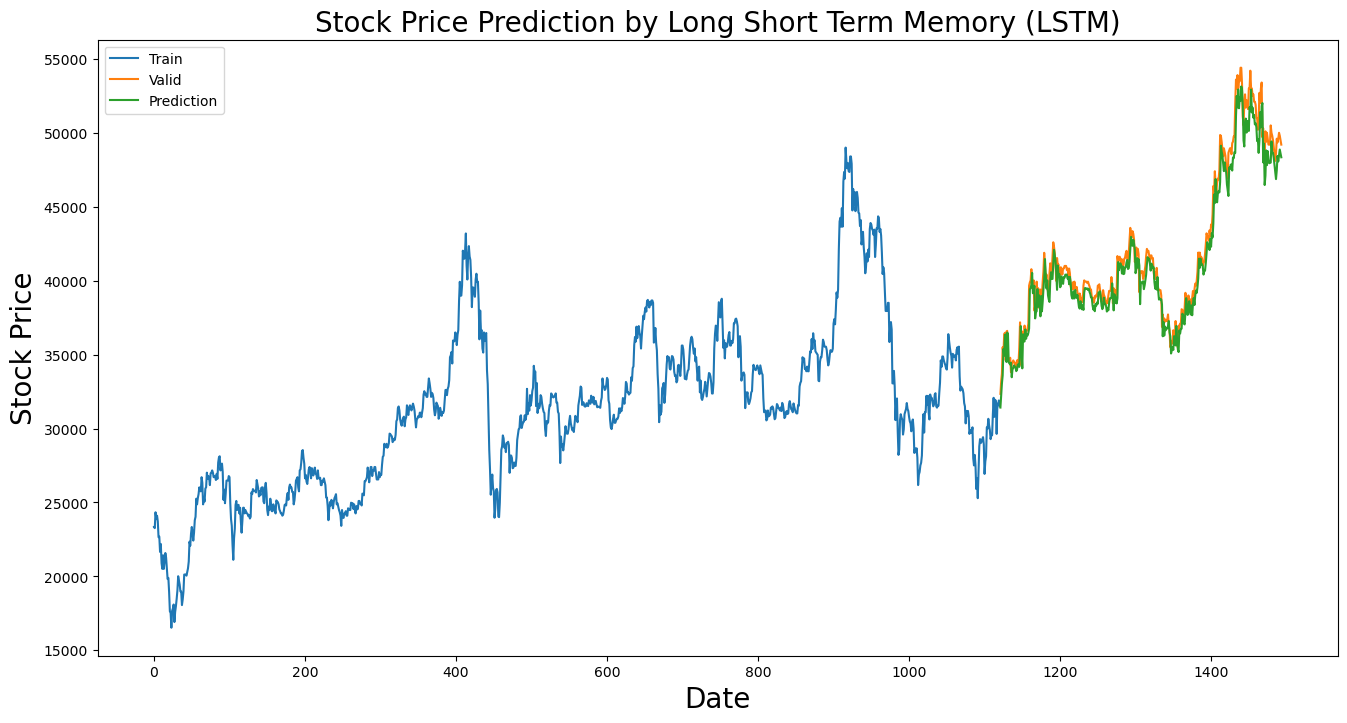

In [73]:
loss_lstm = lstm_prediction(BID_df, epochs=10)

In [79]:
print('Loss of LSTM after 10 epochs over SARIMA:', loss_lstm / loss_sarima) 

Loss of LSTM after 10 epochs over SARIMA: 0.13477271905198757


-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1121, 1)
Shape of Validation Set: (373, 1)
1081/1081 - 12s - loss: 0.0034 - 12s/epoch - 11ms/step
12/12 [==============================] - 1s 5ms/step
RMSE value on validation set: 1256.2868132059514
-----------------------------------------------------------
-----------------------------------------------------------


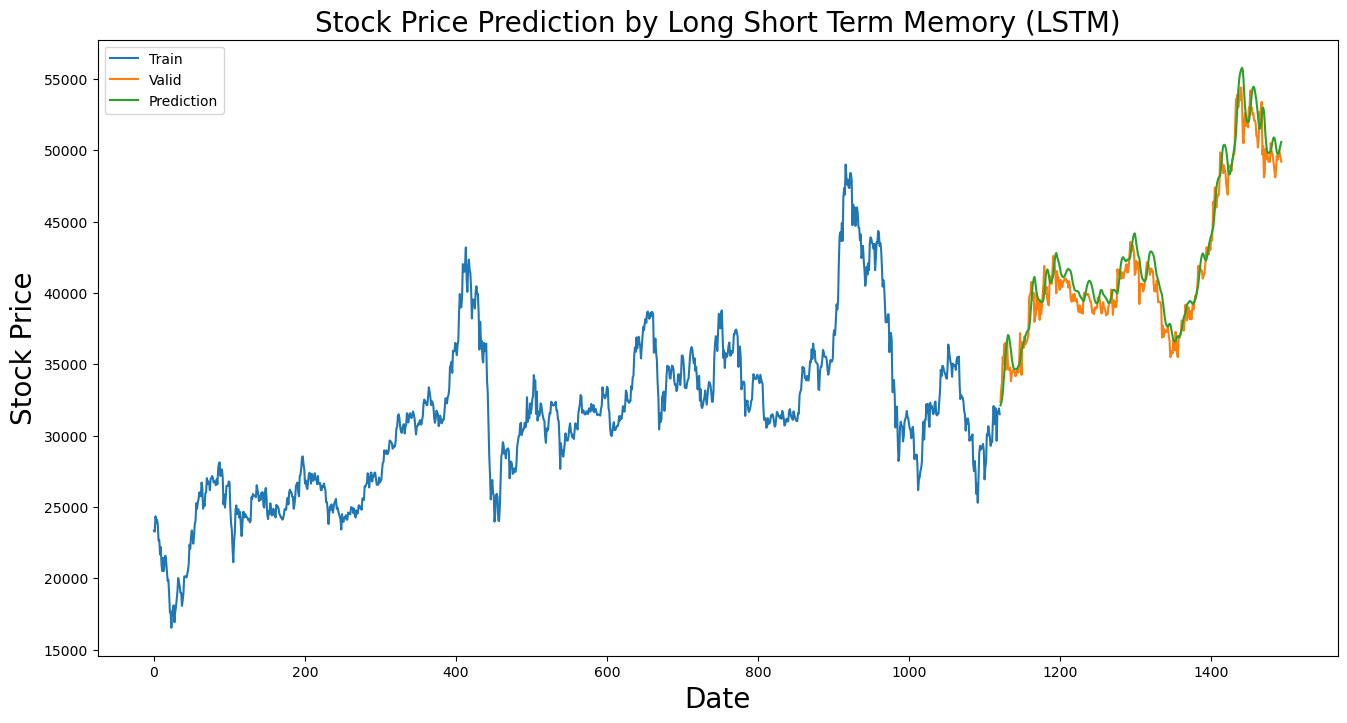

In [78]:
loss_lstm_1 = lstm_prediction(BID_df, epochs=1)

In [81]:
print('Loss of LSTM after 10 epochs over SARIMA:', loss_lstm_1 / loss_sarima) 

Loss of LSTM after 10 epochs over SARIMA: 0.15488852982669063


**Nhận xét:**
- Dựa vào biểu đồ trực quan, ta thấy kết quả dự đoán bởi mô hình LSTM khi huấn luyện qua 10 epochs rất khớp so với giá trị thực tế. Mô hình học được sự biến động phức tạp của dữ liệu thay vì chỉ thực hiện những dự đoán đơn giản như mô hình SARIMA.
- **Về độ chính xác**, ta thấy độ lỗi RMSE của mô hình LSTM trên tập validation thấp hơn nhiều so với mô hình SARIMA (chỉ bằng khoảng 13% khi train qua 10 epochs). Để rút ngắn thời gian huấn luyện mô hình, ta chỉ thực hiện với 1 epochs thì độ khớp của mô hình so với SARIMA vẫn tốt hơn hẳn (độ lỗi khoảng 15% so với SARIMA).
- **Về mức độ dễ sử dụng**, với SARIMA cần đánh giá time series khá phức tạp và đòi hỏi nhiều kinh nghiệm (khảo sát tính dừng của time series, thử nghiệm biến đổi time series để thỏa mãn tính dừng bằng các phép biến đổi khác nhau, chọn order phù hợp cho mô hình). Trong khi đó, SARIMA lại khá đơn giản và không capture được sự biến động phức tạp của một time series về giá cổ phiếu. Trong khi đó, việc xây dựng mô hình LTSM có phần đơn giản hơn với sự hỗ trợ của thư viện (các tham số được học bởi mô hình học sâu nên ta không cần phải chọn tham số như SARIMA). 
- **Về tính giải thích được**, các mô hình học sâu như LSTM có hạn chế hơn. Tuy nhiên khả năng giải thích được của SARIMA không phải là một ưu điểm vượt trội ở đây vì độ chính xác của nó khá thấp và đưa ra giá trị dự đoán sai lệch.